<h1 align="center">Intel Image Classification<font color = 'green'></font></h1>
<h2 align="center">ResNet18 Model<font color='green'></font></h2>
<center>
<img src="https://miro.medium.com/v2/resize:fit:723/1*PJ7iN4xtxRQLcukXz0my8w.png">
</center>

Tody I am presenting to you image classification problem using the Intel Image Classification dataset which is often used in DL and Transfer learning 

The goal is to train a deep learning pretrained model (ResNet18 model) to classify dataset's images into six classes of natural scenes.

The Intel Image Classification dataset contains RGB images (150x150 pixels) of various outdoor scenes, organized into six classes:

1- buildings

2- forest

3- glacier

4- mountain

5- sea

6- street


### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Importing Main libraries needed](#1)
- [Getting the datsaset](#2)
- [Preprocessing the dataset](#3)
- [ResNet model apply](#5)
- [Training the dataset](#6) 
- [visualization](#7)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

<p style="background: rgba(50, 150, 250, 0.3); color: white; text-align: center; font-size: 220%; padding: 10px; border-radius: 10px; margin-bottom: 20px;">
Getting the dataset
</p>

<p style="font-size: 110%; line-height: 1.6;">
First of all, We have build the pytorch custom getdataset class with using (<code>torch.utils.data.Dataset</code>) which is the base class for all datasets.
</p>

<h3 style="color: #2a5298;"><code>__init__</code> :</h3>
<p>
Building the constructor which initializes the object of the class with two arguments:
<ul>
  <li><strong>path</strong> → root directory</li>
  <li><strong>transform</strong> → optional argument with default = None that checks if the dataset will have any transformations or editing.</li>
</ul>
</p>

<p>
<code>self.classes = sorted([d.name for d in self.path.iterdir() if d.is_dir()])</code> : here we have made a dictionary of all classes used from 0 to 5 of all classes used in the dataset.
</p>

<p>
<code>self.image_files = [(file, idx) for cls, idx in self.class_to_idx.items() for file in (self.path / cls).iterdir()]</code> : Collect all files in the dataset as every class has its index, making a tuble which access the file.
</p>

<h3 style="color: #2a5298;"><code>__len__</code> :</h3>
<p>
It return number of all images of the dataset and check that we can read data's images.
</p>

<h3 style="color: #2a5298;"><code>__getitem__(self, idx)</code> :</h3>
<p>
The function goal is getting one sample image of the dataset using its index in the big file.
</p>

<p>
<code>image = Image.open(file)</code> : after getting the file and label from img index it can open the image using PIL.
</p>

<p>
<code>if self.transform:
image = self.transform(image=np.array(image))['image']</code><br>
Here we have the image as PIL so we need to convert it to a numpy array, apply all transformation(augmentation) and return the new img.
</p>
<p>
<code>return image, torch.tensor(label, dtype=torch.long)</code><br>
Return the image and transform the label to a tensor to could be used later.
</p>


In [2]:
class GetDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = Path(path)
        self.transform = transform
        self.classes = sorted([d.name for d in self.path.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.image_files = [(file, idx) for cls, idx in self.class_to_idx.items()  for file in (self.path / cls).iterdir()]

    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        file, label = self.image_files[idx]
        image = Image.open(file)
    
        if self.transform:
            image = self.transform(image) 
        return image, torch.tensor(label, dtype=torch.long)

<p style="background: rgba(50, 150, 250, 0.3); color: white; text-align: center; font-size: 220%; padding: 10px; border-radius: 10px; margin-bottom: 20px;"> Preprocessing the dataset </p> <p style="font-size: 110%; line-height: 1.6;"> In this phase we are ready with our data to work on, we need to add some operation on our images like agmentation , normalization in that class. let us have a journey together in the class </p> <h3 style="color: #2a5298;"><code>__init__(self, train=True)</code> :</h3> <p> The constructor that initializes augmentation transforms and check if we are in the train level not val or test as it has another way of processing than training. </p> <ul> <li><code>transforms.Resize((224, 224))</code> : resizing all images to 124*124 pixels.. why 124*124?? well, it is the most standard shape for cnn architecuters like ResNet</li> <li><code>transforms.RandomHorizontalFlip(p=0.5)</code> : it flips images horizontally by 50% which makes different viewpoints</li> <li><code>transforms.RandomVerticalFlip(p=0.3)</code> : it flips images vertically by 30% which adds variety for scene types</li> <li><code>transforms.RandomRotation(degrees=15)</code> : randomly rotate images by 15 degrees which simulate all cameras views</li> <li><code>transforms.ColorJitter(brightness=0.4, contrast=0.4)</code> : a new feature to be see -by me at least- which randomly adjusts brightness and contrast by up to 40% and simulates different lighting conditions</li> <li><code>transforms.ToTensor()</code> : it checks more that the images has transfered to a tensor</li> <li><code>transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])</code> : it normalizes dataset probility and pretrained models like resnet expect this normalization values</li> </ul> <h3 style="color: #2a5298;"><code>__call__(self, image)</code> :</h3> <p> it make the class works as a function and combine all these transforms in one function to be called while making an object from that class </p>

In [3]:
class Augmentation:
    def __init__(self, train=True):
        if train:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.4, contrast=0.4),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __call__(self, image):
        return self.transform(image)

<p style="background: rgba(50, 150, 250, 0.3); color: white; text-align: center; font-size: 220%; padding: 10px; border-radius: 10px; margin-bottom: 20px;"> ResNet model Apply </p> <p style="font-size: 110%; line-height: 1.6;"> We are ready now to start modeling of the dataset after we have edited it with some transformations. </p> <h3 style="color: #2a5298;"><code>class ResNet18Model(nn.Module)</code> :</h3> <p> It defines a custom neural network model class (it has <code>nn.Module</code> which is the base class for neural networks models). </p> <h3 style="color: #2a5298;"><code>def __init__(self, num_classes=6)</code> :</h3> <p> The constructor initializes the model with 6 classes that has been provided in the beginning of our notebook. </p> <ul> <li><code>super(ResNet18Model, self).__init__()</code> : it calls the super class (<code>nn.Module</code> instructor)</li> <li><code>self.model = models.resnet18(pretrained=True)</code> : it loads pretrained ResNet18 model with the same weights as <code>pretrained=True</code></li> </ul> <p> <code>for param in self.model.parameters(): param.requires_grad = False</code> <br> It freezes all layers parameters which means that these weights will not be updated while training and save pretrained features. </p> <p> <code>for param in self.model.layer4.parameters(): param.requires_grad = True</code> <br> It unfreezes the last layer of the model (layer 4) to make it adapt with our dataset. </p> <p> <code>self.model.fc = nn.Sequential()</code> : it replaces the original fully-connected head as it was designed for 1000 classes. </p> <ul> <li><code>nn.Linear(self.model.fc.in_features, 512)</code> : new linear layer that matches with ResNet's original input features</li> <li><code>nn.ReLU()</code> : Relu helps in good learning</li> <li><code>nn.BatchNorm1d(512)</code> : add a layer of batch normalization to accelerate the convergence</li> <li><code>nn.Dropout(0.5)</code> : drop 50% of neurons which helps in preventing overfitting</li> <li><code>nn.Linear(512, num_classes)</code> : last classification layer to generate our 6 classes needed</li> </ul> <h3 style="color: #2a5298;"><code>def forward(self, x)</code> :</h3> <p> Defining the forward method to build our model </p> <p style="font-size: 110%; margin-top: 20px;"> So now we can construct our model as it is:<br><br> <strong>input → ResNet → (512) Features → ReLU → BatchNorm → Dropout → (6) Output</strong> </p>

In [4]:
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet18Model, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

### Visualizer AI Generated

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

class Visualizer:
    @staticmethod
    def plot_sample_images(dataset, num_images=8, class_names=None):
        """Plot sample images from dataset"""
        indices = torch.randperm(len(dataset))[:num_images]
        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        
        if class_names is None:
            class_names = dataset.classes
            
        for idx, ax in zip(indices, axes):
            image, label = dataset[idx]
            image = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            
            ax.imshow(image)
            ax.set_title(class_names[label])
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss curves
        ax1.plot(train_losses, label='Train')
        ax1.plot(val_losses, label='Validation')
        ax1.set_title('Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Accuracy curves
        ax2.plot(train_accs, label='Train')
        ax2.plot(val_accs, label='Validation')
        ax2.set_title('Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        plt.tight_layout()
        plt.show()

<p style="background: rgba(50, 150, 250, 0.3); color: white; text-align: center; font-size: 220%; padding: 10px; border-radius: 10px; margin-bottom: 20px;"> Training the dataset </p> <p style="font-size: 110%; line-height: 1.6;"> The constructor initializes model parameters. It needs several arguments such as: the model itself, the training loader for training data, <code>val_loader</code> if needed, the number of epochs (default = 10), and the learning rate (default = 0.001). </p> <h3 style="color: #2a5298;"><code>def __init__(self, model, train_loader, val_loader=None, num_epochs=10, learning_rate=0.001)</code> :</h3> <p> We store the variables as follows: </p> <ul> <li><code>self.model = model</code></li> <li><code>self.train_loader = train_loader</code></li> <li><code>self.val_loader = val_loader</code></li> <li><code>self.num_epochs = num_epochs</code></li> <li><code>self.learning_rate = learning_rate</code></li> </ul> <p> Now we set up the device for training. If GPU is available, we use it; otherwise, we work with the CPU: </p> <pre><code>self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") self.model.to(self.device)</code></pre> <p> Here we initialize arrays to track the training and validation losses and accuracies: </p> <pre><code>self.train_losses = [] self.val_losses = [] self.train_accs = [] self.val_accs = []</code></pre> <p> Now, we calculate the class weights, define the loss function, and set the optimizer: </p> <pre><code>self.class_weights = self._calculate_class_weights() self.criterion = nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)</code></pre> <p> AdamW is chosen for better generalization and stable training. It decouples weight decay from the gradient update step, unlike Adam. </p> <p> We also configure the learning rate scheduler to reduce the learning rate when the validation accuracy plateaus: </p> <pre><code>self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', patience=2, factor=0.5)</code></pre> <p> Additionally, we use <code>torch.cuda.amp.GradScaler()</code> for mixed-precision training to speed up training and reduce memory usage: </p> <pre><code>self.scaler = torch.cuda.amp.GradScaler()</code></pre> <h3 style="color: #2a5298;"><code>def train(self)</code> :</h3> <p> In this method, we start the training process: </p> <pre><code>for epoch in range(self.num_epochs): self.model.train() running_loss = 0.0 correct = 0 total = 0</code></pre> <p> We set the model to training mode and initialize variables to track progress. </p> <p> For each batch, we move the inputs and labels to the appropriate device (GPU or CPU): </p> <pre><code>for inputs, labels in self.train_loader: inputs, labels = inputs.to(self.device), labels.to(self.device)</code></pre> <p> We then clear the gradients and use mixed-precision to optimize the model: </p> <pre><code>self.optimizer.zero_grad() with torch.cuda.amp.autocast(): outputs = self.model(inputs) loss = self.criterion(outputs, labels)</code></pre> <p> This mixed-precision supports <code>self.scaler = torch.cuda.amp.GradScaler()</code> and helps optimize backward passes and model updates. </p> <p> If <code>val_loader</code> is provided, we visualize the learning curves: </p> <pre><code>if self.val_loader: Visualizer.plot_learning_curves( self.train_losses, self.val_losses, self.train_accs, self.val_accs )</code></pre> <h3 style="color: #2a5298;"><code>def validate(self)</code> :</h3> <p> In the validation method, we set the model to evaluation mode and track accuracy and loss: </p> <pre><code>self.model.eval() correct = 0 total = 0 val_loss = 0</code></pre> <p> We calculate the loss and accuracy for the validation set and return the results. </p>

In [6]:
class Trainer:
    def __init__(self, model, train_loader, val_loader=None, num_epochs=10, learning_rate=0.001):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'max', patience=2, factor=0.5)
        self.scaler = torch.cuda.amp.GradScaler()
        self.best_val_acc = 0

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss/len(self.train_loader)
            epoch_acc = 100 * correct / total
            self.train_losses.append(epoch_loss)
            self.train_accs.append(epoch_acc)
            val_acc, val_loss = self.validate() if self.val_loader else (0, 0)
            if self.val_loader:
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc)
                self.scheduler.step(val_acc)
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.save_model(path='best_model.pth')
            
            print(f"Epoch {epoch+1}/{self.num_epochs} - "
                  f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        if self.val_loader:
            Visualizer.plot_learning_curves(
                self.train_losses, self.val_losses,
                self.train_accs, self.val_accs
            )

    def validate(self):
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return (100 * correct / total, val_loss/len(self.val_loader))

    def save_model(self, path='best_model.pth'):
        torch.save({
            'epoch': self.num_epochs,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accs': self.train_accs,
            'val_accs': self.val_accs
        }, path)
        print(f"Model saved to {path}")

<p style="background: rgba(50, 150, 250, 0.3); color: white; text-align: center; font-size: 220%; padding: 10px; border-radius: 10px; margin-bottom: 20px;"> Main Time Yaaaayyyyy!!!!!!!!!!!!!! </p> <h3 style="color: #2a5298;"><code>class Main:</code></h3> <p> The <code>Main</code> class acts as the controller for everything we've built so far. It initializes the necessary components and orchestrates the entire training and validation process. </p> <h4 style="color: #2a5298;"><code>def __init__(self, train_path, val_path=None, batch_size=32, num_classes=6, num_epochs=10)</code>:</h4> <p> This method sets up the paths for the training and validation data, batch size (default = 32), number of classes (default = 6), and the number of epochs (default = 10). </p> <p>We initialize our variables like this:</p> <pre><code>self.train_path = train_path self.val_path = val_path self.batch_size = batch_size self.num_classes = num_classes self.num_epochs = num_epochs</code></pre> <h4 style="color: #2a5298;"><code>def run(self)</code>:</h4> <p> This method runs the training and validation process: </p> <ul> <li>First, we load the training dataset and apply data augmentation to it:</li> <pre><code>train_dataset = GetDataset(self.train_path, transform=Augmentation(train=True))</code></pre> <li>For the validation dataset, we load it and apply data transformations but without the augmentation (because we don't need that during validation):</li> <pre><code>val_dataset = GetDataset(self.val_path, transform=Augmentation(train=False)) if self.val_path else None</code></pre> <li>Then, we visualize a sample of the data:</li> <pre><code>Visualizer.plot_sample_images(train_dataset, class_names=train_dataset.classes)</code></pre> <li>Next, we create a data loader for the training dataset:</li> <pre><code>train_loader = DataLoader( train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True )</code></pre> <li>We also create the validation data loader (similar to the training loader) for when we have validation data available:</li> <pre><code>val_loader = DataLoader( val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True ) if self.val_path else None</code></pre> <li>Now, we instantiate the ResNet model:</li> <pre><code>model = ResNet18Model(num_classes=self.num_classes)</code></pre> <li>We initialize the trainer and start the training process:</li> <pre><code>trainer.train()</code></pre> <li>Finally, we save the trained model weights as the final model file:</li> <pre><code>trainer.save_model(path='final_model.pth')</code></pre> </ul>

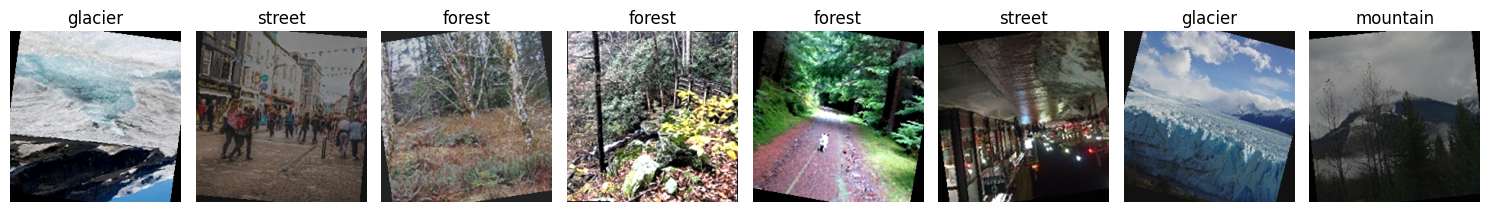

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]
<ipython-input-6-e7b80f5fb76e>:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp

Model saved to best_model.pth
Epoch 1/20 - Train Loss: 0.4253, Acc: 84.94% | Val Loss: 0.2319, Acc: 92.30%
Epoch 2/20 - Train Loss: 0.3320, Acc: 88.79% | Val Loss: 0.2556, Acc: 91.43%
Epoch 3/20 - Train Loss: 0.2995, Acc: 89.45% | Val Loss: 0.2121, Acc: 91.97%
Epoch 4/20 - Train Loss: 0.2726, Acc: 90.31% | Val Loss: 0.2218, Acc: 91.83%
Model saved to best_model.pth
Epoch 5/20 - Train Loss: 0.2240, Acc: 92.08% | Val Loss: 0.2024, Acc: 92.53%
Model saved to best_model.pth
Epoch 6/20 - Train Loss: 0.2059, Acc: 92.66% | Val Loss: 0.1860, Acc: 93.03%
Epoch 7/20 - Train Loss: 0.1988, Acc: 92.99% | Val Loss: 0.1942, Acc: 92.80%
Epoch 8/20 - Train Loss: 0.1900, Acc: 93.30% | Val Loss: 0.2018, Acc: 92.90%
Epoch 9/20 - Train Loss: 0.1730, Acc: 93.77% | Val Loss: 0.2149, Acc: 92.57%
Epoch 10/20 - Train Loss: 0.1481, Acc: 94.76% | Val Loss: 0.2057, Acc: 92.73%
Model saved to best_model.pth
Epoch 11/20 - Train Loss: 0.1242, Acc: 95.83% | Val Loss: 0.1962, Acc: 93.33%
Epoch 12/20 - Train Loss: 0.125

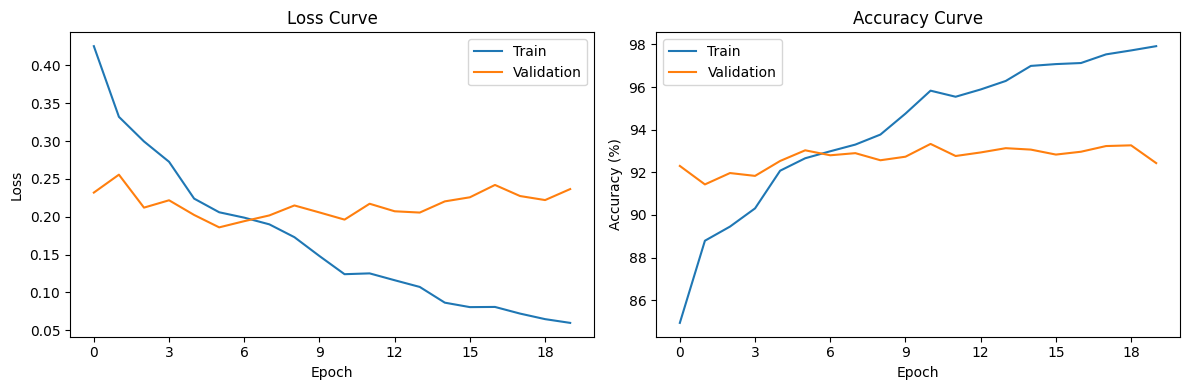

Model saved to best_model.pth


In [7]:
class Main:
    def __init__(self, train_path, val_path=None, batch_size=32, num_classes=6, num_epochs=10):
        self.train_path = train_path
        self.val_path = val_path
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_epochs = num_epochs

    def run(self):
        # Create datasets
        train_dataset = GetDataset(self.train_path, transform=Augmentation(train=True))
        val_dataset = GetDataset(self.val_path, transform=Augmentation(train=False)) if self.val_path else None
        
        # Visualize sample images
        Visualizer.plot_sample_images(train_dataset, class_names=train_dataset.classes)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        ) if val_dataset else None

        # Initialize and train model
        model = ResNet18Model(num_classes=self.num_classes)
        trainer = Trainer(
            model,
            train_loader,
            val_loader,
            num_epochs=self.num_epochs
        )
        trainer.train()
        trainer.save_model(path='best_model.pth')

if __name__ == "__main__":
    train_data = "../input/intel-image-classification/seg_train/seg_train"
    test_data = "../input/intel-image-classification/seg_test/seg_test"
    
    main = Main(
        train_path=train_data,
        val_path=test_data,
        batch_size=32,
        num_classes=6,
        num_epochs=20
    )
    main.run()